In [1]:
import nibabel as nib
import numpy as np

In [6]:
a_path = "/home/roland/uni/thesisprep/ds001420-download/derivatives/petprep/sub-dasb02/ses-baseline/pet/sub-dasb02_ses-baseline_space-MNI152NLin2009cAsym_desc-preproc_pet.nii.gz"
b_path = "/home/roland/uni/thesisprep/ds001420-download/derivatives/petprep/sub-dasb01/ses-rescan/pet/sub-dasb01_ses-rescan_space-MNI152NLin2009cAsym_desc-preproc_pet.nii.gz"
mask_path = "/home/roland/uni/thesisprep/ds001420-download/derivatives/petprep/sub-dasb01/ses-baseline/pet/sub-dasb01_ses-baseline_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"

In [7]:
a = nib.load(a_path)
b = nib.load(b_path)
m = nib.load(mask_path)


In [8]:
A = a.get_fdata(dtype=np.float32)
B = b.get_fdata(dtype=np.float32)
M = m.get_fdata(dtype=np.float32) > 0

In [9]:
assert A.shape == B.shape , (A.shape, B.shape)

assert np.allclose(a.affine, b.affine), "Affines differ, do not do voxel wise compare."

In [10]:
diff = (A - B)
absdiff = np.abs(diff)

In [11]:
print("mean abs diff in mask:", absdiff[M].mean())
print("max abs diff in mask:", absdiff[M].max())
print("p95 abs diff in mask:", np.quantile(absdiff[M], 0.95))

mean abs diff in mask: 10095.168
max abs diff in mask: 940403.5
p95 abs diff in mask: 34344.055


In [ ]:
out = nib.Nifti1Image(absdiff.astype(np.float32), a.affine, a.header)
nib.save(out, "absdiff_MNI_preproc_pet.nii.gz")


mean diff in mask:


PROCESSING OF LOG FILES

In [2]:
import re
from pathlib import Path
import pandas as pd

In [3]:
def extract_finished_workflows(log_file):
    """
    Extract workflow names and execution times from PETPrep log files.
    
    Parameters:
    -----------
    log_file : str or Path
        Path to the log file
        
    Returns:
    --------
    list of dict
        List of dictionaries containing workflow info
    """
    finished_pattern = re.compile(
        r'\[Node\] Finished "([^"]+)", elapsed time ([\d.]+)s\.'
    )
    
    results = []
    
    with open(log_file, 'r') as f:
        for line in f:
            if 'Finished' in line and 'elapsed time' in line:
                match = finished_pattern.search(line)
                if match:
                    workflow_name = match.group(1)
                    elapsed_time = float(match.group(2))
                    
                    results.append({
                        'workflow': workflow_name,
                        'elapsed_time_seconds': elapsed_time,
                        'elapsed_time_minutes': elapsed_time / 60,
                        'elapsed_time_hours': elapsed_time / 3600
                    })
    
    return results

In [14]:
log_file = "logs/output18_fuzzy.txt"  # Change this to your log file path
workflows = extract_finished_workflows(log_file)

print(f"Found {len(workflows)} finished workflows")

Found 283 finished workflows


In [15]:
df = pd.DataFrame(workflows)
df

,workflow,elapsed_time_seconds,elapsed_time_minutes,elapsed_time_hours
0,get_start_frame,0.001022,0.000017,2.838889e-07
1,val_pet,0.021430,0.000357,5.952778e-06
2,pet_source,0.000380,0.000006,1.055556e-07
3,full_wm,0.646861,0.010781,1.796836e-04
4,validate_pet,0.017494,0.000292,4.859444e-06
...,...,...,...,...
278,spike_regressors,0.016982,0.000283,4.717222e-06
279,conf_plot,31.278497,0.521308,8.688471e-03
280,motion_report,464.546686,7.742445,1.290407e-01
281,_msmsulc0,13970.945908,232.849098,3.880818e+00


In [16]:
# group by workflow and compute sum as elapsed time and calculate elapsed time in minutes
grouped = df.groupby('workflow').sum().reset_index()
grouped['elapsed_time_minutes'] = grouped['elapsed_time_seconds'] / 60
grouped['elapsed_time_hours'] = grouped['elapsed_time_seconds'] / 3600

In [17]:
#nlarges 
top_10 = grouped.nlargest(10, 'elapsed_time_seconds')[['workflow', 'elapsed_time_seconds', 'elapsed_time_minutes', 'elapsed_time_hours']]
print("Top 10 longest running workflows:")
top_10

Top 10 longest running workflows:


,workflow,elapsed_time_seconds,elapsed_time_minutes,elapsed_time_hours
143,autorecon2_vol,52085.490840,868.091514,14.468192
76,_msmsulc1,14000.085288,233.334755,3.888913
75,_msmsulc0,13970.945908,232.849098,3.880818
163,est_robust_hmc,4700.044522,78.334075,1.305568
225,run_gtm,4588.635177,76.477253,1.274621
44,_autorecon_surfs1,3687.433580,61.457226,1.024287
43,_autorecon_surfs0,3665.535328,61.092255,1.018204
216,registration,3593.255981,59.887600,0.998127
172,gcareg,3333.151784,55.552530,0.925875
200,norm,2635.134414,43.918907,0.731982


In [9]:
top_10 = df.nlargest(10, 'elapsed_time_seconds')[['workflow', 'elapsed_time_seconds', 'elapsed_time_minutes']]
print("Top 10 longest running workflows:")
top_10

Top 10 longest running workflows:


,workflow,elapsed_time_seconds,elapsed_time_minutes
213,est_robust_hmc,4484.140283,74.735671
224,autorecon2_vol,4168.352257,69.472538
408,_msmsulc1,3207.381001,53.456350
407,_msmsulc0,3178.230414,52.970507
399,run_gtm,3086.267580,51.437793
149,est_robust_hmc,2750.299877,45.838331
300,registration,2138.207244,35.636787
226,_autorecon_surfs0,1398.018295,23.300305
225,_autorecon_surfs1,1353.176321,22.552939
237,_midthickness1,712.662644,11.877711


runtime order from logs

In [18]:
log_fileA = "logs/output26.txt"  # Change this to your log file path
log_fileB = "logs/output27.txt"  # Change this to your log file path
workflowsA = extract_finished_workflows(log_fileA)
workflowsB = extract_finished_workflows(log_fileB)

print(f"Found {len(workflowsA)} finished workflows in {log_fileA}")
print(f"Found {len(workflowsB)} finished workflows in {log_fileB}")

Found 408 finished workflows in logs/output26.txt
Found 408 finished workflows in logs/output27.txt


In [22]:
#Compare the order of workflows 
for (i, wa), (j, wb) in zip(enumerate(workflowsA), enumerate(workflowsB)):
    if wa['workflow'] != wb['workflow']:
        print(f"Difference at position {i}:")
        print(f"  Log A: {wa['workflow']}")
        print(f"  Log B: {wb['workflow']}")
        continue

Difference at position 285:
  Log A: petref2target
  Log B: anat2std_mask
Difference at position 286:
  Log A: anat2std_mask
  Log B: anat2std_dseg
Difference at position 287:
  Log A: anat2std_dseg
  Log B: anat2std_t1w
Difference at position 288:
  Log A: anat2std_t1w
  Log B: sources
Difference at position 289:
  Log A: sources
  Log B: petref2target
Difference at position 290:
  Log A: petref2target
  Log B: sources
Difference at position 291:
  Log A: sources
  Log B: petref2target


create three regions plot for three runs

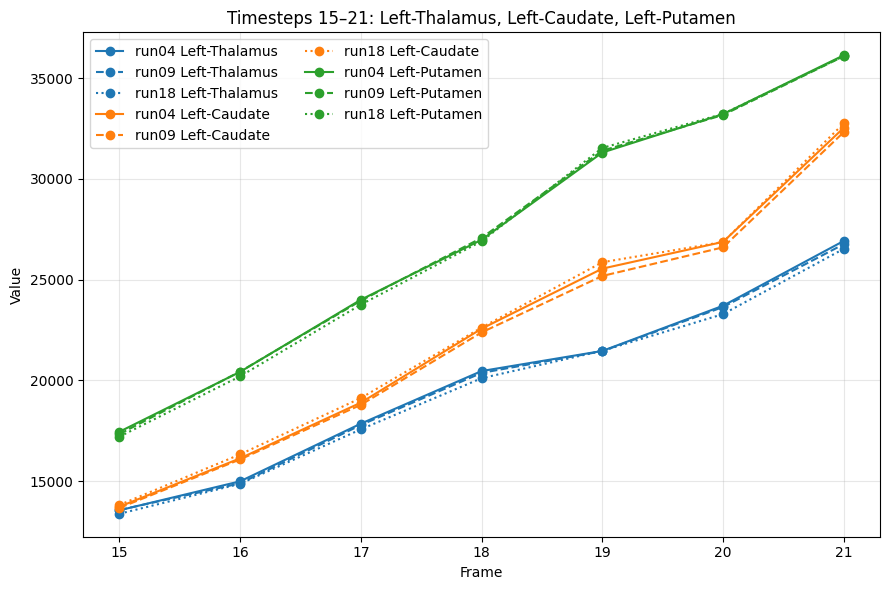

Saved plot to plots/tacs_left_regions.png


,run04 Left-Thalamus,run09 Left-Thalamus,run18 Left-Thalamus,run04 Left-Caudate,run09 Left-Caudate,run18 Left-Caudate,run04 Left-Putamen,run09 Left-Putamen,run18 Left-Putamen
Frame,,,,,,,,,
15,1.355e+04,1.356e+04,1.338e+04,1.373e+04,1.367e+04,1.381e+04,1.745e+04,1.733e+04,1.72e+04
16,1.499e+04,1.489e+04,1.486e+04,1.613e+04,1.607e+04,1.632e+04,2.042e+04,2.043e+04,2.02e+04
17,1.785e+04,1.778e+04,1.757e+04,1.889e+04,1.878e+04,1.912e+04,2.4e+04,2.395e+04,2.376e+04
18,2.046e+04,2.037e+04,2.01e+04,2.256e+04,2.238e+04,2.262e+04,2.697e+04,2.707e+04,2.69e+04
19,2.146e+04,2.144e+04,2.146e+04,2.554e+04,2.518e+04,2.586e+04,3.13e+04,3.139e+04,3.153e+04
20,2.37e+04,2.364e+04,2.329e+04,2.687e+04,2.66e+04,2.686e+04,3.321e+04,3.317e+04,3.322e+04
21,2.692e+04,2.676e+04,2.653e+04,3.253e+04,3.231e+04,3.275e+04,3.613e+04,3.608e+04,3.609e+04


Saved grouped table image to plots/tacs_left_regions_table_grouped.png


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

base = Path("tacs_data")
files = {
    "run04": base / "run04-gtm_tacs.tsv",
    "run09": base / "run09-gtm_tacs.tsv",
    "run18": base / "run18-gtm_tacs.tsv",
}

regions = ["Left-Thalamus", "Left-Caudate", "Left-Putamen"]
region_colors = {
    "Left-Thalamus": "tab:blue",
    "Left-Caudate": "tab:orange",
    "Left-Putamen": "tab:green",
}
linestyles = {"run04": "-", "run09": "--", "run18": ":"}

dfs = {}
for run, path in files.items():
    df = pd.read_csv(path, sep="\t")
    # Select lines 15–21 (1-based) -> 0-based index 14:21
    df_slice = df.iloc[14:21].copy()
    dfs[run] = df_slice

# Build plotting frames per region
plot_frames = {
    region: pd.DataFrame({
        run: d[region].reset_index(drop=True) for run, d in dfs.items()
    })
    for region in regions
}

x_index = range(15, 15 + len(next(iter(plot_frames.values()))))

plt.figure(figsize=(9, 6))
for region in regions:
    for run in plot_frames[region].columns:
        plt.plot(
            x_index,
            plot_frames[region][run],
            marker="o",
            label=f"{run} {region}",
            color=region_colors[region],
            linestyle=linestyles.get(run, "-.")
        )
plt.xlabel("Frame")
plt.ylabel("Value")
plt.title("Timesteps 15–21: Left-Thalamus, Left-Caudate, Left-Putamen")
plt.legend(ncol=2)
plt.grid(alpha=0.3)
plt.tight_layout()
plots_dir = Path("plots")
plots_dir.mkdir(parents=True, exist_ok=True)
out_path = plots_dir / "tacs_left_regions.png"
plt.savefig(out_path, dpi=150)
plt.show()
print(f"Saved plot to {out_path}")

# Values table for quick reference (rows=timestep, columns=run-region)
wide_data = {}
for region in regions:
    for run in plot_frames[region].columns:
        wide_data[f"{run} {region}"] = plot_frames[region][run].values
table_df = pd.DataFrame(wide_data, index=x_index)
table_df.index.name = "Frame"

display(table_df.style.format("{:.4g}").set_caption("TAC values (lines 15–21)"))

# Save grouped-by-region tables as a single image (stacked)
region_tables = {}
for region in regions:
    region_tables[region] = pd.DataFrame({run: plot_frames[region][run].values for run in ["run04", "run09", "run18"]}, index=x_index)
    region_tables[region].index.name = "Frame"

rows_total = sum(len(rt.index) for rt in region_tables.values())
cols_max = max(len(rt.columns) for rt in region_tables.values())
fig_w = max(8, cols_max * 2.2)
fig_h = max(6, rows_total * 0.35 + len(regions) * 1.2)
fig, axes = plt.subplots(nrows=len(regions), ncols=1, figsize=(fig_w, fig_h))
if len(regions) == 1:
    axes = [axes]
for ax, region in zip(axes, regions):
    ax.axis('off')
    rt = region_tables[region].round(4)
    tbl = ax.table(cellText=rt.values, colLabels=list(rt.columns), rowLabels=list(rt.index), cellLoc='center', loc='center')
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(9)
    tbl.scale(1, 1.25)
    ax.set_title(f"{region}", pad=10)
out_table = plots_dir / "tacs_left_regions_table_grouped.png"
plt.savefig(out_table, dpi=150, bbox_inches='tight')
plt.close()
print(f"Saved grouped table image to {out_table}")